In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import requests
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
%pylab inline
import math

Populating the interactive namespace from numpy and matplotlib


In [3]:
import osmnx as ox
%matplotlib inline
ox.config(log_file=True, log_console=True, use_cache=True)

In [4]:
import shapely
from shapely import geometry
import collections
from fiona.crs import from_epsg

In [6]:
#read a csv containing the location, area and elevation of hospitals in Haiti
hospital = pd.read_csv('data/updated_hospital_haiti.csv', encoding = 'ISO-8859-1')

In [7]:
hospital.head()

,area,id,lat,lon,name,elevation
0,2171.482746,461597573,18.489990,-74.454211,Health care,24.581894
1,838.039572,111447496,18.635874,-74.185978,Health care,516.298401
2,84.458676,49238839,18.306875,-74.216624,Les Anglais,14.352342
3,255.340182,50127945,18.471487,-73.943337,HOPITAL SAINT AGNES DE BEAUMONT,596.835510
4,1085.741373,445374620,18.109949,-73.939169,Klinik Timoun Nou Yo,28.644030


# Generate a grid shapefile

1. Mainly for Google map places API,which has a limitation of showing only 60 places in one search. The smaller the searching radius, the more complete results it shows. If we search on a large radius, small amenties won't be showed.

2. Can be used for trajectory analysis, each grid unit's centroid is used as starting point that represent the community covered by it.

## Calculate the grid size

In [8]:
#https://gis.stackexchange.com/questions/2951/algorithm-for-offsetting-a-latitude-longitude-by-some-amount-of-meters
#Find one location to represent the area
lat = 20.218137
lon = -71.62213
R=6378137.0 # Earth’s radius, sphere
dn = 3000.0 #the width of each grid unit in meters
de = 3000.0 #the height of each grid unit in meters
# Coordinate offsets in radians
dLat = dn/R
dLon = de/(R*math.cos(math.pi*lat/180))
# OffsetPosition, decimal degrees
latO = dLat * 180/math.pi # the corresponding latitude for each grid unit's width
lonO = dLon * 180/math.pi # the corresponding latitude for each grid unit's height

In [9]:
latO

0.026949458523585643

In [10]:
lonO

0.028719019035553437

### Use the script grid.py to make shapefile

!python grid.py shapefile_name lat_min lat_max lon_min lon_max gridHeight gridWidth

In [11]:
!python grid.py grid.shp -75.238462 -71.62213 17.909929 20.218137 0.026949458523585643 0.028719019035553437

In [15]:
htshp = gpd.GeoDataFrame.from_file('data/grid.shp')

In [14]:
htshp.shape

(10836, 2)

In [1]:
from IPython.display import Image

### the shapefile is a fish net with same size grids covering Haiti

![title](data/Haiti.png)

### Haiti boudary shapefile

In [21]:
haiti = gpd.GeoDataFrame.from_file('data/haiti_boundary/haiti_adm4_minustah.shp')

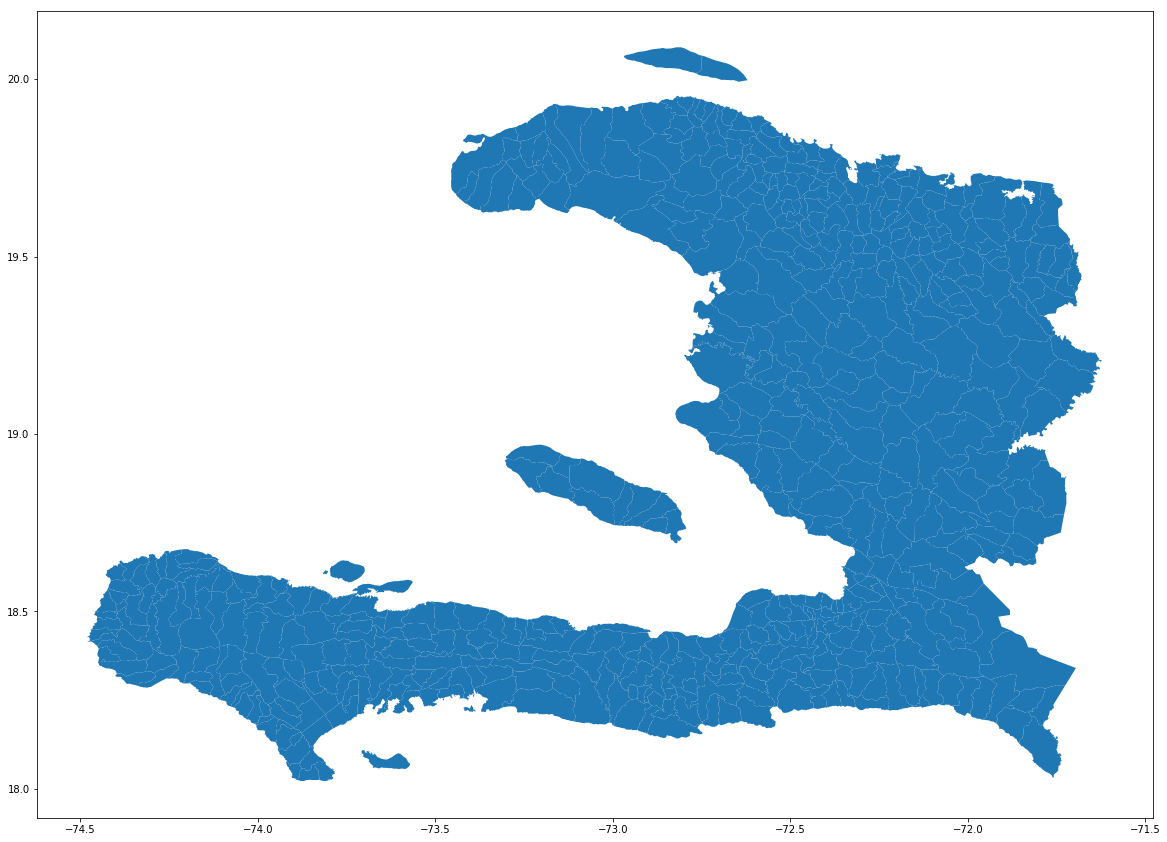

In [22]:
haiti.plot()

# Cap Haitian trajectory analysis

In [249]:
nord = haiti.loc[haiti['ADM1'] =='Nord'].reset_index(drop = True)
#choose the Nord department

In [250]:
nord.shape

(82, 16)

In [251]:
nord.head()

,Shape_Leng,Shape_Area,ID_ADM1,ADM1,ID_ADM2,ADM2,ID_ADM3,NOM_ADM3,ADM3,NO_ADM4,ID_ADM4,NOM_ADM4,ADM4,Shape_Le_1,Shape_Ar_1,geometry
0,0.447220,0.004663,3.0,Nord,31.0,Cap Haïtien,311.0,Cap Haitien,CAP HAITIEN,1.0,311-01,1ère Bande du Nord,BANDE DU NORD,0.256953,0.001803,POLYGON ((-72.25911463799991 19.75947563400007...
1,0.447220,0.004663,3.0,Nord,31.0,Cap Haïtien,311.0,Cap Haitien,CAP HAITIEN,2.0,311-02,2ème Haut du Cap,HAUT DU CAP,0.294533,0.001642,POLYGON ((-72.19418556399995 19.76728980900009...
2,0.447220,0.004663,3.0,Nord,31.0,Cap Haïtien,311.0,Cap Haitien,CAP HAITIEN,3.0,311-03,3ème Petite Anse,PETITE ANSE,0.216189,0.001218,POLYGON ((-72.20204696299993 19.75072814000009...
3,0.519295,0.005138,3.0,Nord,31.0,Cap Haïtien,312.0,Quartier Morin,QUARTIER MORIN,1.0,312-01,1ère Basse Plaine,BASSE PLAINE,0.291194,0.002361,POLYGON ((-72.13279830699992 19.75231329600007...
4,0.519295,0.005138,3.0,Nord,31.0,Cap Haïtien,312.0,Quartier Morin,QUARTIER MORIN,2.0,312-02,3ème Morne Pelé,MORNE PELEE,0.323177,0.002776,"POLYGON ((-72.1489032369999 19.69004060700007,..."


### Find centroid of each grid unit

In this analysis, each grid area is represented by the centroid. The gird area's distance to an amenity is represented by the distance from its centroid to the amenity.

In [252]:
location_points = [[0] * 3 for x in range(htshp.shape[0])]
for i in range(htshp.shape[0]):
    polygon_location = list(htshp.geometry[i].exterior.coords)
    central_lon = (polygon_location[0][0] + polygon_location[2][0])/2.0
    central_lat = (polygon_location[0][1] + polygon_location[2][1])/2.0
    location_points[i][0] = central_lon
    location_points[i][1] = central_lat
    location_points[i][2] = htshp.FID[i]

In [253]:
points_df = gpd.GeoDataFrame(location_points, columns=['lon', 'lat', 'FID'])

In [254]:
points_df.head()

,lon,lat,FID
0,-75.224102,20.204662,0
1,-75.224102,20.177713,1
2,-75.224102,20.150763,2
3,-75.224102,20.123814,3
4,-75.224102,20.096864,4


In [255]:
points_df.shape

(10836, 3)

In [256]:
points_df['lat'] = points_df['lat'].astype(float)
points_df['lon'] = points_df['lon'].astype(float)

In [257]:
points_df.head()

,lon,lat,FID
0,-75.224102,20.204662,0
1,-75.224102,20.177713,1
2,-75.224102,20.150763,2
3,-75.224102,20.123814,3
4,-75.224102,20.096864,4


### transform the geodataframe into a shapefile

In [259]:
nord.crs = from_epsg(2263)
points_df['lonlat'] = list(zip(points_df.lon.values, points_df.lat.values))
points_df['geometry'] = points_df['lonlat'].map(lambda x: shapely.geometry.Point(list(x)))
points_df.crs = from_epsg(2263)
nord_point = gpd.sjoin(points_df, nord, op='within')[['FID','lat','lon', 'ADM1']]
nord_point = nord_point.reset_index(drop = True)

In [260]:
nord_point.shape

(232, 4)

### nord_point is the points within cap haitien

In [261]:
nord_point.head()

,FID,lat,lon,ADM1
0,7668,19.827370,-72.668110,Nord
1,7669,19.800420,-72.668110,Nord
2,7754,19.827370,-72.639391,Nord
3,7755,19.800420,-72.639391,Nord
4,7757,19.746521,-72.639391,Nord


In [368]:
htshp.head() # the grid

,FID,geometry
0,0,"POLYGON ((-75.238462 20.218137, -75.2097429809..."
1,1,"POLYGON ((-75.238462 20.19118754147641, -75.20..."
2,2,"POLYGON ((-75.238462 20.16423808295283, -75.20..."
3,3,"POLYGON ((-75.238462 20.13728862442924, -75.20..."
4,4,"POLYGON ((-75.238462 20.11033916590566, -75.20..."


# nord population

In [370]:
#add geometry of each grid unit to each row, so we can get the population for each row
nord_grid = nord_point.merge(htshp,left_on = 'FID', right_on = 'FID')

In [371]:
from rasterstats import zonal_stats
population = [0] * nord_grid.shape[0]
for i in range(nord_grid.shape[0]):
    population[i] = zonal_stats(nord_grid.geometry.iloc[i],'pop.tif')[0]['mean']

In [374]:
#Each of our grid unit is 3000 meters by 3000 meters. While the unit in the population layer
# is 100 meters by 100 meters, so we need to convert the unit
3000.0**2 / 100.**2

900.0

In [380]:
population = [ i * 900.0 for i in population]

In [382]:
nord_grid.shape

(232, 5)

In [385]:
len(population)

232

# find hospitals within Cap Haitien

In [262]:
#all the hospitals in haiti
hospital.head()

,id,lat,lon,area,name
0,221673492,19.846544,-72.522796,150.585236,HOPE(CORPUS CHRISTI)
1,630828976,19.850000,-72.533333,303.168177,HíÇpital Borgne
2,629031321,19.838870,-72.515121,303.168177,DISPENSAIRE HOSPITALIER DU BORGNE
3,1280526469,19.843691,-72.523259,303.168177,Health care
4,49549670,19.683265,-72.319345,249.884195,Centre de Sante Notre Dame de la Nativite Acul...


In [263]:
nord.head()

,Shape_Leng,Shape_Area,ID_ADM1,ADM1,ID_ADM2,ADM2,ID_ADM3,NOM_ADM3,ADM3,NO_ADM4,ID_ADM4,NOM_ADM4,ADM4,Shape_Le_1,Shape_Ar_1,geometry
index_right,,,,,,,,,,,,,,,,
0,0.447220,0.004663,3.0,Nord,31.0,Cap Haïtien,311.0,Cap Haitien,CAP HAITIEN,1.0,311-01,1ère Bande du Nord,BANDE DU NORD,0.256953,0.001803,POLYGON ((-72.25911463799991 19.75947563400007...
1,0.447220,0.004663,3.0,Nord,31.0,Cap Haïtien,311.0,Cap Haitien,CAP HAITIEN,2.0,311-02,2ème Haut du Cap,HAUT DU CAP,0.294533,0.001642,POLYGON ((-72.19418556399995 19.76728980900009...
2,0.447220,0.004663,3.0,Nord,31.0,Cap Haïtien,311.0,Cap Haitien,CAP HAITIEN,3.0,311-03,3ème Petite Anse,PETITE ANSE,0.216189,0.001218,POLYGON ((-72.20204696299993 19.75072814000009...
3,0.519295,0.005138,3.0,Nord,31.0,Cap Haïtien,312.0,Quartier Morin,QUARTIER MORIN,1.0,312-01,1ère Basse Plaine,BASSE PLAINE,0.291194,0.002361,POLYGON ((-72.13279830699992 19.75231329600007...
4,0.519295,0.005138,3.0,Nord,31.0,Cap Haïtien,312.0,Quartier Morin,QUARTIER MORIN,2.0,312-02,3ème Morne Pelé,MORNE PELEE,0.323177,0.002776,"POLYGON ((-72.1489032369999 19.69004060700007,..."


In [264]:
hospital['lonlat'] = list(zip(hospital.lon.values, hospital.lat.values))
hospital['geometry'] = hospital['lonlat'].map(lambda x: shapely.geometry.Point(list(x)))
hospital.crs = from_epsg(2263)
nord_hospital = gpd.sjoin(hospital, nord, op='within')[['id','lat','lon', 'area', 'name']]
nord_hospital = nord_hospital.reset_index(drop = True)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  This is separate from the ipykernel package so we can avoid doing imports until


In [597]:
nord_hospital.head()

,id,lat,lon,area,name
0,221673492,19.846544,-72.522796,150.585236,HOPE(CORPUS CHRISTI)
1,630828976,19.850000,-72.533333,303.168177,HíÇpital Borgne
2,629031321,19.838870,-72.515121,303.168177,DISPENSAIRE HOSPITALIER DU BORGNE
3,1280526469,19.843691,-72.523259,303.168177,Health care
4,49549670,19.683265,-72.319345,249.884195,Centre de Sante Notre Dame de la Nativite Acul...


nord # boundary
nord_point #centroid
nord_hospital #hospitals in Cap Haitien

In [266]:
from shapely.ops import nearest_points

In [267]:
from shapely.geometry import Point, MultiPoint

In [275]:
hospital = pd.read_csv('updated_hospital_haiti.csv', encoding = 'ISO-8859-1')

### Find the nearest hospital for each grid unit's centroid

In [276]:
def get_nearest(building, centroid_df):
    """
    building is the df of hospitals: hospital
    centroid_df is the df of centrol points of grids: nord_point
    """
    center_df = centroid_df.copy()
    destination = []
    for i in range(building.shape[0]):
        #build a list of Points
        destination.append(Point(building.lat[i], building.lon[i]))
    #MultiPoint makes it possible to compare one location with multiple points
    des_list = MultiPoint(destination) 
    nearest_lat = [] 
    nearest_lon = [] 
    for i in range(center_df.shape[0]):
        #starting point of each trajectory
        orig = Point(center_df.lat[i], center_df.lon[i]) 
        #get the nearest hospital for each starting point
        nearest_geoms = nearest_points(orig, des_list) 
        #extract the nearest hospital's lat
        nearest_lat.append(nearest_geoms[1].coords.xy[0].tolist()[0]) 
        #extract the nearest hospital's lon
        nearest_lon.append(nearest_geoms[1].coords.xy[1].tolist()[0])
    center_df['nearest_lat'] = nearest_lat
    center_df['nearest_lon'] = nearest_lon
    
    return center_df

In [277]:
get_nearest(nord_hospital, nord_point)

,FID,lat,lon,ADM1,nearest_lat,nearest_lon
0,7668,19.827370,-72.668110,Nord,19.811724,-72.573288
1,7669,19.800420,-72.668110,Nord,19.811724,-72.573288
2,7754,19.827370,-72.639391,Nord,19.811724,-72.573288
3,7755,19.800420,-72.639391,Nord,19.811724,-72.573288
4,7757,19.746521,-72.639391,Nord,19.807892,-72.572522
5,7929,19.746521,-72.581953,Nord,19.692767,-72.552938
6,7930,19.719572,-72.581953,Nord,19.692767,-72.552938
7,7840,19.827370,-72.610672,Nord,19.811724,-72.573288
8,7841,19.800420,-72.610672,Nord,19.807892,-72.572522
9,7927,19.800420,-72.581953,Nord,19.807892,-72.572522


### Get the distance from each grid unit's centroid to its nearest hospital

In [ ]:
import osmnx as ox, networkx as nx
#download the road network in Haiti
G = ox.graph_from_place('Haiti', network_type='drive_service') 
def nearest_distance(df):
    distance = [99999999.0] * df.shape[0] #have a distance list in advance
    for i in range(df.shape[0]):
        origin_point = (df.lat[i],df.lon[i])
        destination_point = (df.nearest_lat[i], df.nearest_lon[i])
        #assign the nearest node from the network to each starting point
        origin_node = ox.get_nearest_node(G, origin_point) 
        #assign the nearest node from the network to each hospital
        destination_node = ox.get_nearest_node(G, destination_point)
        #get the route from starting node to hospital node
        route = nx.shortest_path(G, origin_node, destination_node, weight='length')
        #convert the distance to kilometers
        route_length_km = sum([G.adj[u][v][0]['length'] for u, v in zip(route, route[1:])]) / 1000.
        distance[i] = route_length_km

    return distance

In [319]:
import osmnx as ox, networkx as nx

### Take out hospitals one by one to see how trajectory changes

In [300]:
def get_all_distance(building,centroid_df):
    """
    building is the df of hospitals: hospital
    centroid_df is the df of centrol points of grids: nord_point
    """
# distance_group is a list of dataframe, each dataframe shows the distance from 
#each grid unit to the nearest hospital
# building.shape[0]+1, the last 1 means when there's no hospital taken out
    distance_group = [[]] * (building.shape[0]+1)
    #calculate the distance when all hospitals are kept
    distance_group[-1] = nearest_distance(get_nearest(building, centroid_df))#all hospitals kept
    for i in range(building.shape[0]):
        #drop hospitals one by one
        current = building.drop(building.index[i]).reset_index(drop = True)
        distance_group[i] = nearest_distance(get_nearest(current, centroid_df))
        print(i)
    return distance_group

In [302]:
hospital_ditance_list =  get_all_distance(nord_hospital, nord_point)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108


In [491]:
import operator

In [309]:
htshp.head()

,FID,geometry
0,0,"POLYGON ((-75.238462 20.218137, -75.2097429809..."
1,1,"POLYGON ((-75.238462 20.19118754147641, -75.20..."
2,2,"POLYGON ((-75.238462 20.16423808295283, -75.20..."
3,3,"POLYGON ((-75.238462 20.13728862442924, -75.20..."
4,4,"POLYGON ((-75.238462 20.11033916590566, -75.20..."


### Build a dataframe to add weights to travel distance by population for each situation when one hospital is removed

In [569]:
nord_grid = pd.merge(nord_point,htshp, on = 'FID')[['FID', 'geometry']]
#df_list is a list of dataframe, each dataframe is when one hospital is removed
df_list = [[]] * len(hospital_ditance_list)
for i in range(len(hospital_ditance_list)):
    df = nord_grid.copy()
    df['hospital'] = hospital_ditance_list[i] #the distance to the nearest hosptal for each grid
    df['population'] = population
    df['without removing this hosptial travel distance'] = hospital_ditance_list[-1] #the last
#dataframe is when all hospital are kept
    df['additional distance'] = [0 if j < 0 else j for j in map(operator.sub, hospital_ditance_list[i], hospital_ditance_list[-1])]
#calculate the additional travel distance while keep the additional travel time larger than 0
    df_list[i] = df
    df.to_csv('hospital_nord_result/nord_hospital_{}.csv'.format(i), index = None)

### Caculate weighted distance based on the dataframes we got from the codes above

In [570]:
without_access_grid = [[]] * len(df_list)
without_access_population = [[]] * len(df_list)
travel_distance = [[]] * len(df_list)
additional_travel_distance = [[]] * len(df_list)
additional_distance_population_index = [[]] * len(df_list)
for i in range(len(df_list)):
    without_access_grid[i] = df_list[i].loc[df_list[i]['hospital'] == 0].shape[0]
    without_access_population[i] = df_list[i].loc[df_list[i]['hospital'] == 0, 'population'].sum()
    travel_distance[i] = df_list[i].hospital.sum()
    additional_travel_distance = df_list[i]['additional distance'].sum()
    additional_distance_population_index[i] = sum(df_list[i]['additional distance'] * df_list[i].population)
    

    

In [572]:
df_1 = pd.DataFrame({'Additional Travel Distance':additional_travel_distance, 'Additional Distance Population Index':\
                     additional_distance_population_index,'No. area grid without access': without_access_grid, \
                     'Population without access':without_access_population,  \
                     'Total travel distance':travel_distance})



In [578]:
df_1

,Additional Distance Population Index,Additional Travel Distance,No. area grid without access,Population without access,Total travel distance
0,0.000000,0.0,28,104628.516357,1774.304625
1,951.976052,0.0,27,101614.092826,1774.620432
2,1309.813053,0.0,27,101222.190781,1774.816273
3,0.000000,0.0,28,104628.516357,1774.304625
4,22063.364317,0.0,28,104628.516357,1778.401370
5,3593.500587,0.0,28,104628.516357,1777.075338
6,0.000000,0.0,28,104628.516357,1774.304625
7,6003.645350,0.0,28,104628.516357,1745.698427
8,0.000000,0.0,28,104628.516357,1772.537626
9,22308.843643,0.0,28,104628.516357,1775.194409


In [600]:
df_1.to_csv('hosptial_accessibility.csv', index = None,encoding='latin-1')

In [483]:
nord_hospital.to_csv('nord_hospital.csv',index=None,encoding='latin-1')

### Get the names of the hospitals

In [586]:
nord_hospital['name']

0                                   HOPE(CORPUS CHRISTI)
1                                        HíÇpital Borgne
2                      DISPENSAIRE HOSPITALIER DU BORGNE
3                                            Health care
4      Centre de Sante Notre Dame de la Nativite Acul...
5                   Centre Mí©dical de Secours Chrí©tien
6                                   DISPENSAIRE DE TOVAR
7                              DISPENSAIRE LA DELIVRANCE
8                                 DISPENSAIRE LA BRUYERE
9                                        Hopital Sarepta
10                                    Hpital Justinien
11                                Dispensaire de Labadie
12                        Dispensaire Solano SA, Labadie
13     Centre de Sante Merlin Medical Relief Lasling ...
14     CENTRE DISPENSAIRE NOTRE DAME DE LOURDES CARENAGE
15                                         CENTRE FOSREF
16                        HíÇpital Christ du Nord (Dash)
17                             

In [587]:
df_1['Hospital Name'] = nord_hospital['name']

In [592]:
df_1[['Hospital Name', 'Additional Distance Population Index']].sort_values(['Additional Distance Population Index'], ascending = False).reset_index(drop = True)

,Hospital Name,Additional Distance Population Index
0,Disp de Bas Limbí©,106802.284549
1,DISPENSAIRE DE GOBERT,100029.947933
2,Cap-Haitien Hospital Psychiatric,91902.400326
3,Hopital le Bon Samaritain (HBS),83778.919874
4,CENTRE DE SANTE DE BAYEUX,81222.421304
5,Centre de sante Porte ouverte,75223.262430
6,CENTRE DE SANTE SAINT MALACHY,74041.085272
7,Hopital Sacrí© Coeur de Milot,65168.696010
8,HOPITAL ESPERANCE DE PILATE,52005.564345
9,DispansíÂ komotíÂ de ravin díÂ Roch,39498.834788
